In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import kagglehub

# Download the dataset using kagglehub
path = kagglehub.dataset_download("datamunge/sign-language-mnist")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [4]:
downloaded_files = os.listdir(path)
print(downloaded_files)

['american_sign_language.PNG', 'sign_mnist_train', 'sign_mnist_test.csv', 'sign_mnist_train.csv', 'amer_sign3.png', 'amer_sign2.png', 'sign_mnist_test']


In [5]:
data_train = pd.read_csv(path + '/sign_mnist_train.csv')
data_test = pd.read_csv(path + '/sign_mnist_test.csv')

In [6]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
data_train.size

21552175

In [8]:
print("Training data shape:", data_train.shape)
print("Test data shape:", data_test.shape)

Training data shape: (27455, 785)
Test data shape: (7172, 785)


In [9]:
# Separate features and labels
training_images = data_train.iloc[:, 1:].values #Get all the rows, starting from the second column since the first column is the label.
training_labels = data_train.iloc[:, 0].values # Extract the label column (first column) as the target variable

testing_images = data_test.iloc[:, 1:].values
testing_labels = data_test.iloc[:, 0].values

In [10]:
# Reshape and normalize images
training_images = training_images.reshape(-1, 28, 28, 1)
testing_images = testing_images.reshape(-1, 28, 28, 1)

- Reshape the images to include the channel dimension.
- The images in the dataset are grayscale, meaning each pixel has a single intensity value, so we need to specify that there is only one color channel (1).
- By reshaping the data to (-1, 28, 28, 1), we are preparing it for input into the convolutional neural network (CNN).
Here:
- -1 is used to infer the number of samples (images) automatically.
- 28 and 28 are the height and width of each image. We have 784 columns.
- 1 indicates a single channel (since the images are grayscale).
This reshaping ensures that the model can correctly interpret the input data for the convolution layers, which expect data in the format (samples, height, width, channels).

- Color images typically use the RGB color model, which means each pixel has 3 values representing the Red, Green, and Blue channels. These are the three primary colors used to create the full spectrum of colors.
- For color images, the shape would have 3 channels instead of 1.
- For example:
-- Grayscale Image (1 channel): Shape will be (height, width, 1)
-- RGB Color Image (3 channels): Shape will be (height, width, 3)

In [11]:
print("Training images shape:", training_images.shape)
print(training_labels.shape)
print("Testing images shape:", testing_images.shape)
print(testing_labels.shape)

Training images shape: (27455, 28, 28, 1)
(27455,)
Testing images shape: (7172, 28, 28, 1)
(7172,)


In [12]:
# Normalize pixel values to range [0, 1]
training_images = training_images / 255.0
testing_images = testing_images / 255.0

1. Pixel Values:

- Each pixel in an image can have a value between 0 and 255 in the case of an 8-bit grayscale or RGB image.
- For grayscale images, the pixel value represents the brightness of the pixel, where 0 is black, 255 is white, and values in between represent varying shades of gray.
- For color images, each of the Red, Green, and Blue channels also has values between 0 and 255.

---
2. Why divide by 255?

- Scaling the pixel values to a range between 0 and 1 helps the model train faster and more stably. Neural networks work best when the input values are small (typically in the range of 0 to 1), as this can speed up convergence and reduce the likelihood of certain problems during training, such as:
-- Vanishing Gradient Problem: When the input values are too large, gradients can become too small, making learning slower or even causing the network to stop learning.
-- Faster Convergence: Normalizing helps the optimizer make updates to weights more efficiently, which speeds up the training process.
---
3. What happens when we divide by 255?

- A pixel value of 0 stays as 0 (black).
- A pixel value of 128 becomes 128/255 ≈ 0.50.
- A pixel value of 255 becomes 255/255 = 1 (white).

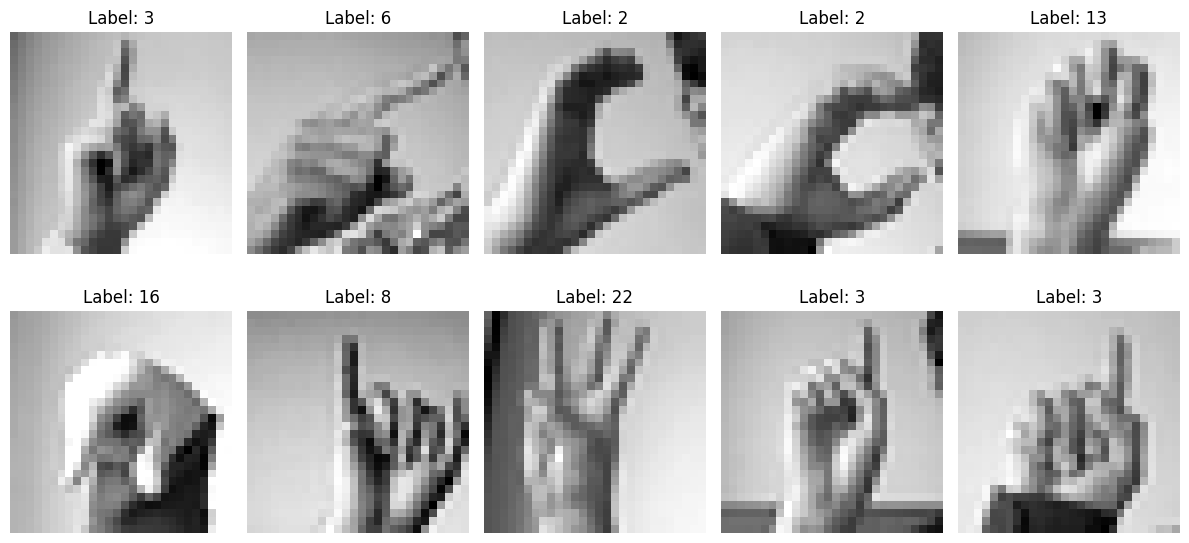

In [13]:
# Visualize sample images
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(training_images[i].reshape(28,28), cmap='gray')
    plt.title(f'Label: {training_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1.0, # No additional scaling since we've already normalized the data.
    rotation_range=15, # Rotate images randomly by up to 15 degrees.
    width_shift_range=0.15, # Shift images horizontally by up to 15%.
    height_shift_range=0.15, # Shift images vertically by up to 15%.
    zoom_range=0.2, # Randomly zoom in/out by up to 20%.
    horizontal_flip=False # No horizontal flipping since sign language depends on orientation.
)

In [15]:
# Apply augmentation only to training data
train_generator = train_datagen.flow(training_images, training_labels, batch_size=32)

In [16]:
# Validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0)
validation_generator = validation_datagen.flow(testing_images, testing_labels, batch_size=32)

In [17]:
# Define the CNN Model
# Convolutional Neural Networks (CNNs) are used for image classification tasks.
model = tf.keras.models.Sequential([
    # First Conv2D layer: Extracts basic patterns like edges.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(), # Normalize activations for stability.
    tf.keras.layers.MaxPooling2D(2, 2),  # Reduce image dimensions to focus on significant features.

    # Second Conv2D layer: Learns more complex patterns.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Third Conv2D layer: Extracts higher-level features.
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten: Converts 2D feature maps into a 1D vector for input into dense layers.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), # Fully connected dense layer with 256 neurons.
    tf.keras.layers.Dropout(0.5), # Prevent overfitting by randomly dropping neurons during training.

    # Output layer with 26 neurons (one for each letter A-Z).
    tf.keras.layers.Dense(26, activation='softmax') # Softmax gives probabilities for each class.
])

In [18]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Suitable for multi-class classification.
    metrics=['accuracy']
)

In [19]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch=len(training_images) // 32,
    validation_steps=len(testing_images) // 32
)

In [20]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(testing_images, testing_labels, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

225/225 - 2s - 11ms/step - accuracy: 0.9784 - loss: 0.0767
Test Accuracy: 0.98


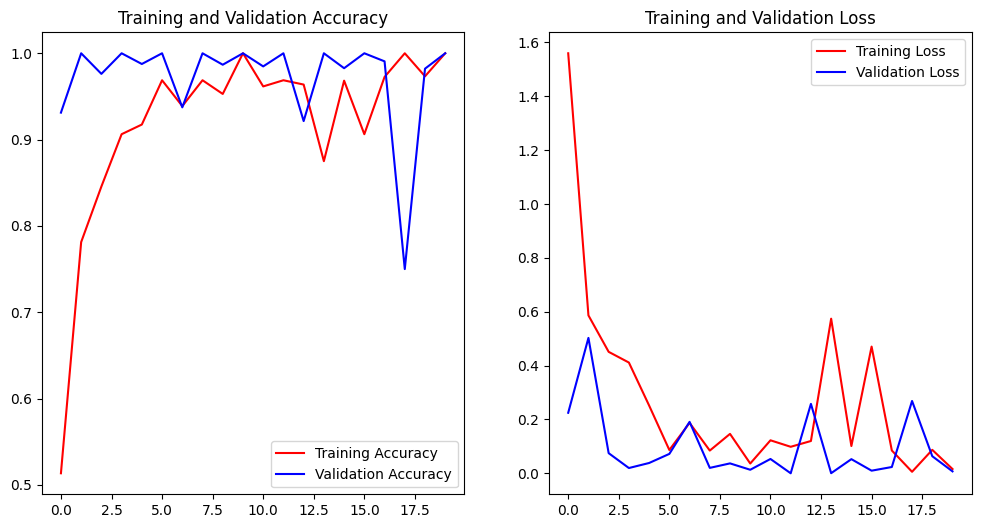

In [21]:
# Plot training and validation accuracy/loss
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [22]:
# Predictions and Evaluation
predictions = model.predict(testing_images)
predicted_labels = np.argmax(predictions, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


In [23]:
# Classification Report
print("\nClassification Report:")
print(classification_report(testing_labels, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      0.94      0.97       245
           4       1.00      0.95      0.98       498
           5       1.00      1.00      1.00       247
           6       0.88      1.00      0.93       348
           7       1.00      0.89      0.94       436
           8       1.00      1.00      1.00       288
          10       0.99      0.98      0.99       331
          11       1.00      1.00      1.00       209
          12       1.00      0.96      0.98       394
          13       0.82      1.00      0.90       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       0.99      1.00      1.00       164
          17       1.00      0.91      0.95       144
   

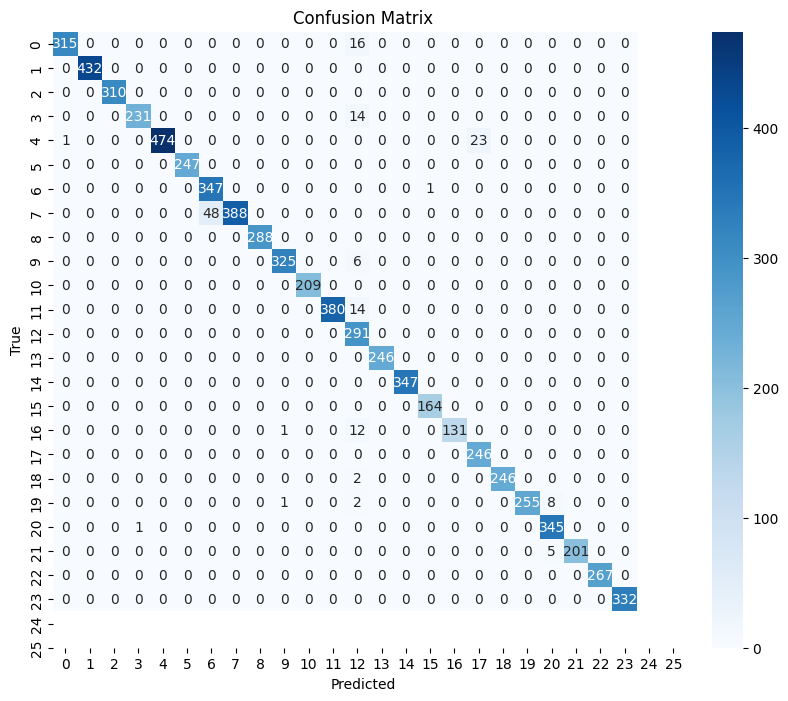

In [24]:
# Confusion Matrix
cm = confusion_matrix(testing_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(26)), yticklabels=list(range(26)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()